In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import math

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100


In [3]:
wx = pd.read_csv('../data/wx/wx-frontier-agg.csv')
wx = wx[wx.YEAR <= 2015]
wx.tail()

,INDEX,YEAR,GSP,GDD,GSTmax,GSTmin,frost,summer,HWI,CWI,dry,wet,PRCP95P
70,70,2011,2.235671,1428.125,24.988415,12.427744,2,92,9,10,14,4,0
71,71,2012,1.259451,1458.000,26.367683,11.412805,9,107,11,11,27,3,0
72,72,2013,3.569817,1394.850,24.716463,12.293902,4,82,7,10,21,15,0
73,73,2014,3.509146,1235.675,23.610366,11.458841,6,82,6,13,14,7,0
74,74,2015,3.650000,1381.625,24.535671,12.313415,2,89,3,11,21,5,1


In [4]:
ag = pd.read_csv('../data/agri/frontiers/Processed_Iowa+Cerro+Gordo_1960+2009_Annual+Crop.csv')
ag = ag.sort_values('Year')
ag.tail()

,Program,Year,Period,Geo Level,State,Ag District,County,Commodity,Data Item,Domain Category,Value
4,SURVEY,2013,YEAR,COUNTY,IOWA,NORTH CENTRAL,CERRO GORDO,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",NOT SPECIFIED,163.1
3,SURVEY,2014,YEAR,COUNTY,IOWA,NORTH CENTRAL,CERRO GORDO,SOYBEANS,"SOYBEANS - YIELD, MEASURED IN BU / ACRE",NOT SPECIFIED,50.2
2,SURVEY,2014,YEAR,COUNTY,IOWA,NORTH CENTRAL,CERRO GORDO,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",NOT SPECIFIED,168.3
1,SURVEY,2015,YEAR,COUNTY,IOWA,NORTH CENTRAL,CERRO GORDO,SOYBEANS,"SOYBEANS - YIELD, MEASURED IN BU / ACRE",NOT SPECIFIED,58.9
0,SURVEY,2015,YEAR,COUNTY,IOWA,NORTH CENTRAL,CERRO GORDO,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",NOT SPECIFIED,196.9


In [5]:
corn = ag.loc[(ag['Data Item'].str.contains('BU / ACRE')) & (ag['Commodity'] == 'CORN')].copy()
beans = ag.loc[(ag['Data Item'].str.contains('BU / ACRE')) & (ag['Commodity'] == 'SOYBEANS')].copy()

corn['YEAR'] = corn.Year
beans['YEAR'] = beans.Year

corn['Value'] = corn.Value.astype('float')
beans['Value'] = beans.Value.astype('float')

corn = corn[['YEAR', 'Value']]
beans = beans[['YEAR', 'Value']]

corn.head()

,YEAR,Value
150,1940,51.8
148,1941,46.5
146,1942,56.3
144,1943,56.6
142,1944,49.8


In [6]:
def gauss_kde(v):
    """
        Implementation of Eqtn 5
        
        Used as a multivariate kernel density estimator
        
        v - a vector for either univariate or bivariate cases
    """
    # paper eq 5
    p = []
    N = len(v)
    
    if v.ndim == 1:
        d = 1
    else:
        # the data is a many rows of features, each row contains 'd' 
        # elements
        d = v.shape[1]
        sigma = np.cov(v, rowvar = False)
        sigma_inv = np.linalg.pinv(sigma)
        sigma_det = np.linalg.det(sigma)
        
    # bandwidth
    h = pow(4/(d+2), 1/(d+4)) * pow(N, -1/(d+4))
    
    # this coeffcient is constant across the whole computation
    coeff = (1 / math.sqrt(pow(2*math.pi, d)))
    if v.ndim == 2:
        coeff *= 1 / math.sqrt(sigma_det)
    
    for x in v:
        s = 0
        # for every row, compute the probability using all the other rows
        # and the Gaussian distribution
        for xi in v:
            u = x - xi
            if v.ndim == 1:
                exp = -u * u
            else:
                exp = -np.matmul(np.matmul(u, sigma_inv), u.T)
            s += coeff * math.exp(exp / (2 * h * h))
            
        # scaled by the number of samples and the bandwith^d
        s /= (N * pow(h, d))
        
        p.append(s)
    return p

In [7]:
def estimate_mi(X, Y):
    """
        Implementation of Eqtn 4
        
        Estimates the MI for any bivariate data
        set (X;Y)
        
        X - Vector containing information about specific feature
        Y - Vector containing information on crop yield values
        
        Returns: scalar value serving as the MI estimation for (X;Y)
    """
    
    # Obtaining number of data points
    N = len(X)
    
    # P_y is the PDF of Y
    P_y = gauss_kde(Y)
    
    # P_x is the PDF of X
    P_x = gauss_kde(X)
    
    # Obtaining bivariate data
    XY = np.vstack((X, Y)).T
    
    # P_xy is the joint PDF of X, Y
    P_xy = gauss_kde(XY)
    
    # Obtaining the estimate
    s = 0
    for i in range(len(P_x)):
        s += math.log(P_xy[i] / (P_x[i] * P_y[i]))
    s /= N
    
    if (s < 0):
        s = 0
    
    return s

In [8]:
def scale_mi(mi):
    """
        Implementation of Eqtn 6
    
        Scales the estimated MI values to be within the
        range of [0. 1]
        
        mi - a list containing all MI estimates
        
        Returns a list of the scaled elements
    """
    
    scaled_mi = []
    
    for i in mi:
        
        s = math.sqrt(1 - math.exp(-2 * i))
        scaled_mi.append(s)
        
    return scaled_mi

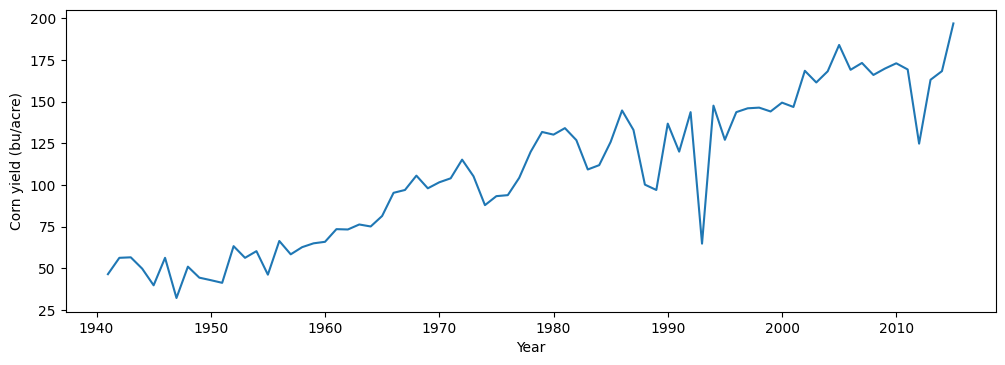

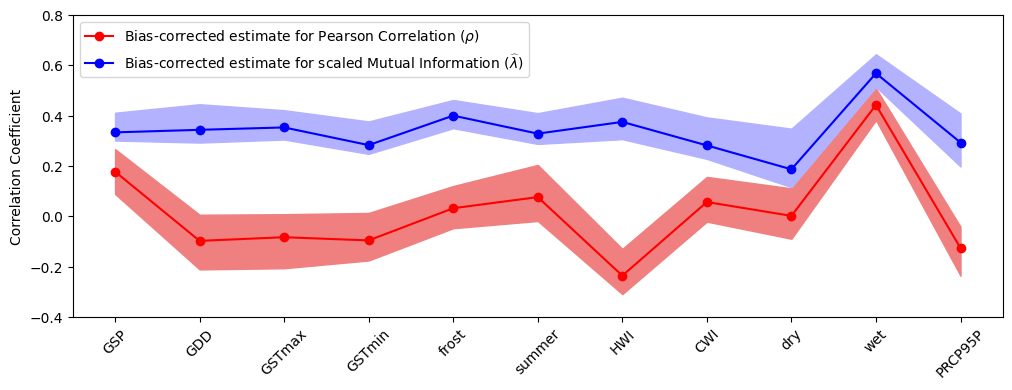

In [9]:
comb = wx.merge(corn, on='YEAR')
x = ['GSP', 'GDD', 'GSTmax', 'GSTmin', 'frost', 'summer', 'HWI', 'CWI', 'dry', 'wet', 'PRCP95P']

plt.plot(comb.YEAR, comb.Value)
plt.xlabel('Year')
plt.ylabel('Corn yield (bu/acre)')
#plt.savefig('yield.png')
plt.show()

#
# Normalize 
#
def norm(s):
    return (s - s.mean()) / s.std()

for f in x:
    comb[f] = norm(comb[f])
comb['Value'] = norm(comb.Value)


#
# compute the Pearson bias for each value with jackknife resampling
#
series = {}
for feat in x:
    s = []
    for n in range(0, 100):
        samples = comb.sample(frac=0.8)
        c = samples[[feat, 'Value']].corr()
        s.append(c[feat].Value)
        
    series[feat] = pd.Series(s)
    
#  
# p_df is all the jacknife samples
#
p_df = pd.DataFrame(series)

# pstar - mean of results of corr over all jackknife samples
# p     - results of running corr on original samples
# pbias  - pbias computed between pstar and p
# pbar  - unbiased correlation
pstar = p_df.mean()  
p = comb.corr().Value[x]
pbias = pstar - p
pbar = p - pbias

p_errlow = p_df.quantile(q=0.05)
p_errhigh = p_df.quantile(q=0.95)

#
# Compute the MI bias for each value with jackknife resampling
#
series = {}
for feat in x:
    s = []
    for n in range(0, 100):
        samples = comb.sample(frac=0.8)
        c = estimate_mi(samples[feat], samples.Value.values)
        s.append(c)
    
    s = scale_mi(s)
    series[feat] = pd.Series(s)
    
#
# mi_df is all jackknife samples
#
mi_df = pd.DataFrame(series)

# Estimating MI
est_mi = []

for feat in x:
    est_mi.append(estimate_mi(comb[feat], comb.Value.values))
    
# scaled = scale_mi(est_mi)

# l_star   - mean of results of MI over all jackknife samples
# l_scaled - result of scaling calculated estimated MI
# l_bias   - The bias computed between l_star and l_scaled
# l_bar    - the biased corrected estimater
l_star = mi_df.mean()
l_scaled = scale_mi(est_mi)
l_bias = l_star - l_scaled
l_bar = l_scaled - l_bias

l_errlow = mi_df.quantile(q=0.05)
l_errhigh = mi_df.quantile(q=0.95)

plt.plot(x, pbar, '-o', color='red', label=r"Bias-corrected estimate for Pearson Correlation ($\rho$)")
plt.plot(x, l_scaled, '-o', color='blue', label=r"Bias-corrected estimate for scaled Mutual Information ($\widehat{\lambda}$)")
plt.fill_between(x, p_errlow, p_errhigh, color='lightcoral')
plt.fill_between(x, l_errlow, l_errhigh, color='#B3B2FE')
plt.ylim(-0.4, 0.8)
plt.ylabel('Correlation Coefficient')
plt.legend()
ax = plt.gca()
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
plt.savefig('corr.png')

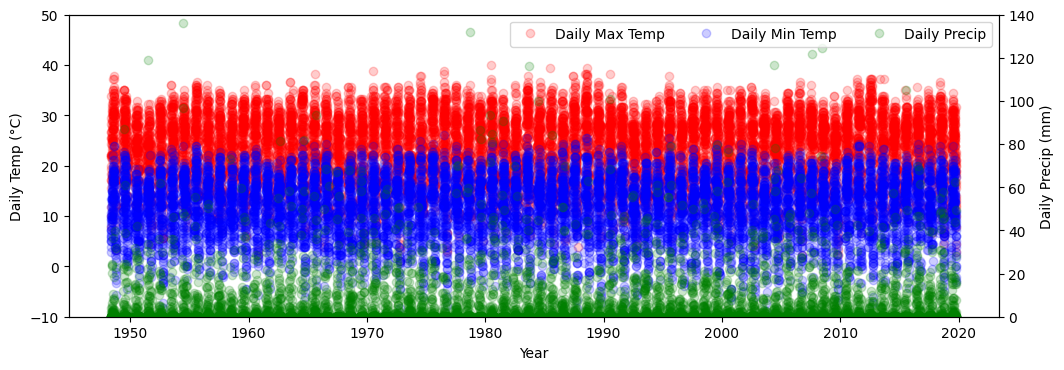

In [10]:
data = ['USC00135230.csv', 'USC00137572.csv', 'USW00014940.csv']
data = data[2:3]

dataroot = '../data/wx/ghcnd'
frames = [pd.read_csv(dataroot + '/' + x, low_memory=False) for x in data]

pframes = [f for f in frames if 'PRCP' in f.columns]
tframes = [f for f in frames if 'TMIN' in f.columns]

def summarize(frames, cols):
    c = ['DATE'] + cols
    p = [f[c].copy() for f in frames]
    pp = []
    for (i, f) in enumerate(p):
        newcols = ['%s%i' % (x,i) for x in cols]
        for (old, new) in zip(cols, newcols):
            f[new] = f[old]
        pp.append(f.drop(cols, axis=1))
    
    df = pp[0]
    for df2 in pp[1:]:
        df = df.merge(df2, on='DATE', how='outer')
    
    df.DATE = pd.to_datetime(df.DATE)
    df = df.sort_values('DATE')
    df = df[(df.DATE >= '1941-01-01') & (df.DATE <= '2019-12-31')]
    
    mask = df.DATE.map(lambda x: (x.month == 5 and x.day >= 10) or (x.month > 5 and x.month < 10) or (x.month == 10 and x.day <= 20))
    
    df = df[mask]
    
    for c in cols:
        ic = ['%s%i' % (c,i) for i in range(len(pp))]
        df[c] = df[ic].mean(axis=1)
        df = df.drop(ic, axis=1)

    return df
    
    
prcp = summarize(pframes, ['PRCP'])
prcp.PRCP = prcp.PRCP * 0.1

temp = summarize(tframes, ['TMIN', 'TMAX'])
temp.TMIN = temp.TMIN * 0.1
temp.TMAX = temp.TMAX * 0.1

temp['year'] = temp.DATE.map(lambda d: d.year)

wxdata = prcp.merge(temp, on='DATE', how='outer')

n = 10000
delta = len(wxdata) // n 
wxdata = wxdata.iloc[range(0, len(prcp), delta)]

fig, ax1 = plt.subplots()
ax1.set_xlabel('Year')
ax1.set_ylabel('Daily Temp (°C)')
ax1.set_ylim(-10, 50)

alpha = 0.2

p1 = ax1.plot(wxdata.DATE, wxdata.TMAX, 'o', color='red', alpha=alpha, label='Daily Max Temp')
p2 = ax1.plot(wxdata.DATE, wxdata.TMIN, 'o', color='blue', alpha=alpha, label='Daily Min Temp')

ax2 = ax1.twinx()
ax2.set_ylim(0, 140)
ax2.set_ylabel('Daily Precip (mm)')

p3 = ax2.plot(wxdata.DATE, wxdata.PRCP, 'o', color='green', alpha=alpha, label='Daily Precip')

ps = p1 + p2 + p3
ax2.legend(ps, map(lambda l: l.get_label(), ps), loc=0, ncol = 3)

plt.show()

#ax1.plot(wxdata.DATE, wxdata.PRCP)


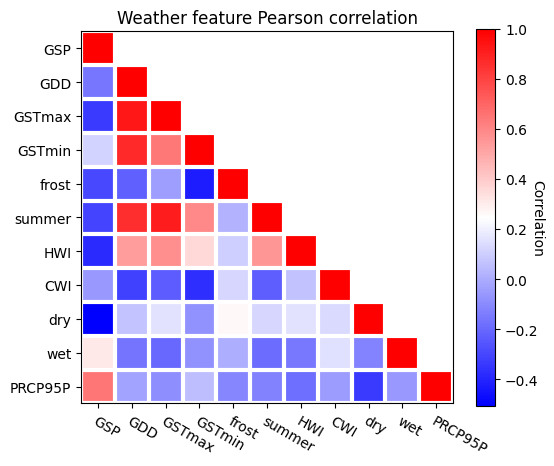

In [47]:
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

feats = ['GSP', 'GDD', 'GSTmax', 'GSTmin', 'frost', 'summer', 'HWI', 'CWI', 'dry', 'wet', 'PRCP95P']
wxcorr = wx[feats].corr()
lower = np.tril(np.ones(wxcorr.shape)).astype(bool)
wxcorr = wxcorr.where(lower)
ax = plt.gca()
im = ax.imshow(wxcorr,cmap="bwr")
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Correlation', rotation=-90)
ax.set_xticks(np.arange(len(feats)))
ax.set_yticks(np.arange(len(feats)))
ax.set_xticklabels(feats)
ax.set_yticklabels(feats)
ax.set_title("Weather feature Pearson correlation")

ax.set_xticks(np.arange(len(feats)+1)-.5, minor=True)
ax.set_yticks(np.arange(len(feats)+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)
plt.setp(ax.get_xticklabels(), rotation=-30, ha="left",
             rotation_mode="anchor")
plt.savefig('wxcorr.png')
plt.show()